In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


gdf = gpd.read_file("C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg")

# Before optimization

### Check what percentage of people have to walk a distance greater than 1500 metres to a drugstore in Salzburg

In [3]:
# Load the new GeoPackage file (assumed to be already saved with the new columns)
new_gpkg_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"
gdf = gpd.read_file(new_gpkg_path)

# Filter data for people who have to walk more than 1500 meters
people_above_1500m = gdf[gdf['adjusted_ex_distance'] > 1500]

# Sum the distributed population for those people
total_population_above_1500m = people_above_1500m['distributed_population'].sum()

# Sum the total distributed population
total_population = gdf['distributed_population'].sum()

# Calculate the percentage of the population that has to walk more than 1500 meters
percentage_above_1500m = (total_population_above_1500m / total_population) * 100

# Display the results
print(f"{total_population_above_1500m:.0f} people have to walk more than 1500 meters to reach a drugstore.")
print(f"{percentage_above_1500m:.2f}% of the population has to walk more than 1500 meters to reach a drugstore.")


32076 people have to walk more than 1500 meters to reach a drugstore.
20.31% of the population has to walk more than 1500 meters to reach a drugstore.


#### Check the number of residents and their distance walking over 1500 meters

Number of people who need to walk more than 1500 meters before new drugstores: 32076.0


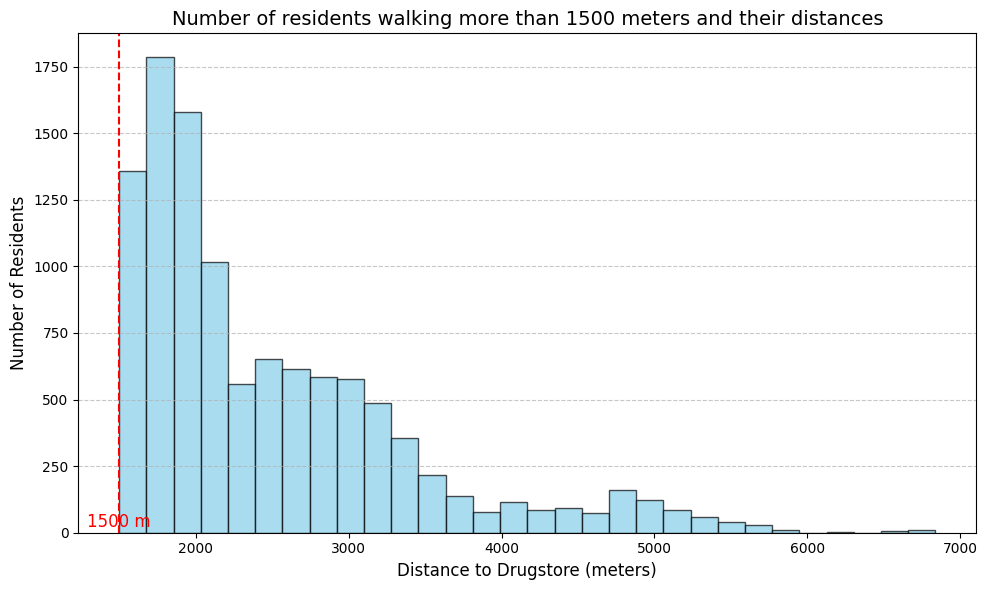

In [4]:
# 1. Number of people who must walk more than 1500 meters before new drugstores are opened
over_1500_before = gdf[gdf['adjusted_ex_distance'] > 1500]
num_over_1500_before = over_1500_before['distributed_population'].sum()

print(f"Number of people who need to walk more than 1500 meters before new drugstores: {num_over_1500_before}")

# 2. Plot histogram of distances for these people
plt.figure(figsize=(10, 6))

# Histogram of walking distances before building new drugstores
plt.hist(over_1500_before['adjusted_ex_distance'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical line at 1500 meters threshold
plt.axvline(x=1500, color='red', linestyle='--')

# Add label '1500' under x-axis at the vertical line
plt.text(1500, plt.ylim()[0] + 5, '1500 m', color='red', fontsize=12, ha='center', va='bottom')

# Plot settings
plt.title('Number of residents walking more than 1500 meters and their distances', fontsize=14)
plt.xlabel('Distance to Drugstore (meters)', fontsize=12)
plt.ylabel('Number of Residents', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot with tight layout
plt.tight_layout()
plt.show()


#### Checking which districts have how many people without a drugstore within 1500 meters

In [5]:
# Filter data for people who have to walk more than 1500 meters
people_above_1500m = gdf[gdf['adjusted_ex_distance'] > 1500]

# Group by district and sum the distributed population
population_by_district = people_above_1500m.groupby('district_name')['distributed_population'].sum()

# Display the result
print("Total distributed population by district for people who have to walk more than 1500 meters:")
print(population_by_district)


Total distributed population by district for people who have to walk more than 1500 meters:
district_name
Aigen / Glas                                   2097.0
Gaisberg                                        131.0
Gnigl / Langwied                               2481.0
Hellbrunn                                       229.0
Itzling                                         208.0
Itzling-West / Hagenau                          730.0
Josefiau / Alpenstrasse-Ost                      41.0
Kapuzinerberg / Steinviertel                     33.0
Kleingmain / Morzg                              578.0
Leopoldskron / Moos                            7955.0
Liefering-Nord                                 6127.0
Liefering-Ost                                   683.0
Liefering-West                                    6.0
Maxglan                                         212.0
Maxglan / Flughafen                            3583.0
Maxglan / Riedenburg                             41.0
Monchsberg / Inneres Nonntal /

#### Classify city districts based on the presence of a drogerie (drugstore) and whether people in those districts have to walk more than 1500 meters to reach one.

The classification has three categories:

- "No drogerie, people > 1500m" – Districts that do not have a drogerie and contain residents who must walk more than 1500 meters to reach one.

- "Has drogerie, people > 1500m" – Districts that have a drogerie but still contain residents located more than 1500 meters away from it.

- "Has drogerie, all served" – Districts that have a drogerie and all residents are within a 1500-meter walking distance.

In [11]:
import geopandas as gpd

# Load the data
districts_path = "C:/Users/Yoanna/Downloads/utm_updated_zaehlbezirk.gpkg"
old_drogeries_path = "C:/Users/Yoanna/Downloads/retro_drogeries.gpkg"
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"

districts = gpd.read_file(districts_path)          # Districts
old_drogeries = gpd.read_file(old_drogeries_path)  # Existing drogeries
utm_centroids = gpd.read_file(utm_centroids_path)  # Centroids with population and distances

# Group data for residents who have to walk more than 1500 meters
people_above_1500m = utm_centroids[utm_centroids['adjusted_ex_distance'] > 1500]
population_by_district = people_above_1500m.groupby('district_name')['distributed_population'].sum()

# Add a column to the districts showing the number of people walking more than 1500 meters
districts = districts.merge(population_by_district, how='left', left_on='NAME', right_on='district_name')
districts['distributed_population'] = districts['distributed_population'].fillna(0)  # Replace NaN with 0

# Find the districts that contain at least one drogerie
districts_with_drogerie = old_drogeries['district_name'].unique()

# Classification of districts
districts['category'] = 'No drogerie, people > 1500m'  # Default: no drogerie and people walking >1500m
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] > 0),
    'category'
] = 'Has drogerie, people > 1500m'
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] == 0),
    'category'
] = 'Has drogerie, all served'

# Results
no_drogerie = districts[districts['category'] == 'No drogerie, people > 1500m']
has_drogerie_people = districts[districts['category'] == 'Has drogerie, people > 1500m']
has_drogerie_all_served = districts[districts['category'] == 'Has drogerie, all served']

print("Districts without drogerie and people > 1500m:")
print(no_drogerie[['NAME', 'distributed_population']])

print("\nDistricts with drogerie and people > 1500m:")
print(has_drogerie_people[['NAME', 'distributed_population']])

print("\nDistricts with drogerie and all served:")
print(has_drogerie_all_served[['NAME']])


Districts without drogerie and people > 1500m:
                                           NAME  distributed_population
1                                     Hellbrunn                   229.0
2                               Thumegg / Gneis                     0.0
4                              Gnigl / Langwied                  2481.0
5                           Parsch-West / Aigen                   449.0
6                                Liefering-Nord                  6127.0
9                                       Maxglan                   212.0
10  Monchsberg / Inneres Nonntal / Leopoldskron                    18.0
12                                 Sam / Kasern                  3393.0
14                                     Neustadt                     0.0
16                          Leopoldskron / Moos                  7955.0
19                           Parsch-Ost / Aigen                  1808.0
20                                     Gaisberg                   131.0
21               

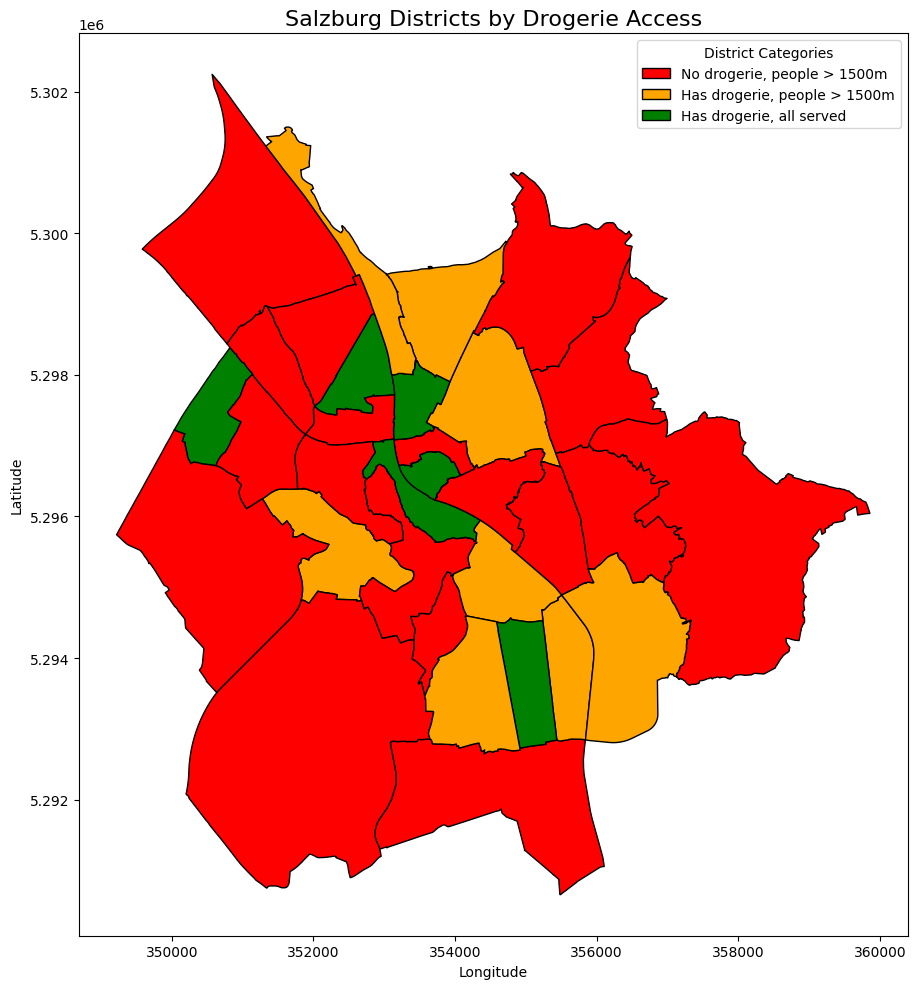

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- 1. Load the spatial data ---
districts_path = "C:/Users/Yoanna/Downloads/utm_updated_zaehlbezirk.gpkg"
old_drogeries_path = "C:/Users/Yoanna/Downloads/retro_drogeries.gpkg"
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"

districts = gpd.read_file(districts_path)
old_drogeries = gpd.read_file(old_drogeries_path)
utm_centroids = gpd.read_file(utm_centroids_path)

# --- 2. Filter people who are more than 1500 meters away from a drogerie ---
people_above_1500m = utm_centroids[utm_centroids['adjusted_ex_distance'] > 1500]
population_by_district = people_above_1500m.groupby('district_name')['distributed_population'].sum()

# --- 3. Merge the population data into the districts data ---
districts = districts.merge(population_by_district, how='left', left_on='NAME', right_on='district_name')
districts['distributed_population'] = districts['distributed_population'].fillna(0)

# --- 4. Identify districts that already have a drogerie ---
districts_with_drogerie = old_drogeries['district_name'].unique()

# --- 5. Categorize districts based on drogerie access ---
districts['category'] = 'No drogerie, people > 1500m'
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] > 0),
    'category'
] = 'Has drogerie, people > 1500m'
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] == 0),
    'category'
] = 'Has drogerie, all served'

# --- 6. Define colors for each category ---
category_colors = {
    'No drogerie, people > 1500m': 'red',
    'Has drogerie, people > 1500m': 'orange',
    'Has drogerie, all served': 'green'
}

# Map colors to each district; fallback to 'gray' for unexpected values
districts['color'] = districts['category'].map(category_colors).fillna('gray')

# --- 7. Plot the map visualization ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot districts colored by drogerie access category
districts.plot(ax=ax, color=districts['color'], edgecolor='black')

# Manually define the legend
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='No drogerie, people > 1500m'),
    Patch(facecolor='orange', edgecolor='black', label='Has drogerie, people > 1500m'),
    Patch(facecolor='green', edgecolor='black', label='Has drogerie, all served'),
    #Patch(facecolor='gray', edgecolor='black', label='Unknown category')
]
ax.legend(handles=legend_elements, title="District Categories", loc='upper right')

# Add title and axis labels
plt.title("Salzburg Districts by Drogerie Access", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


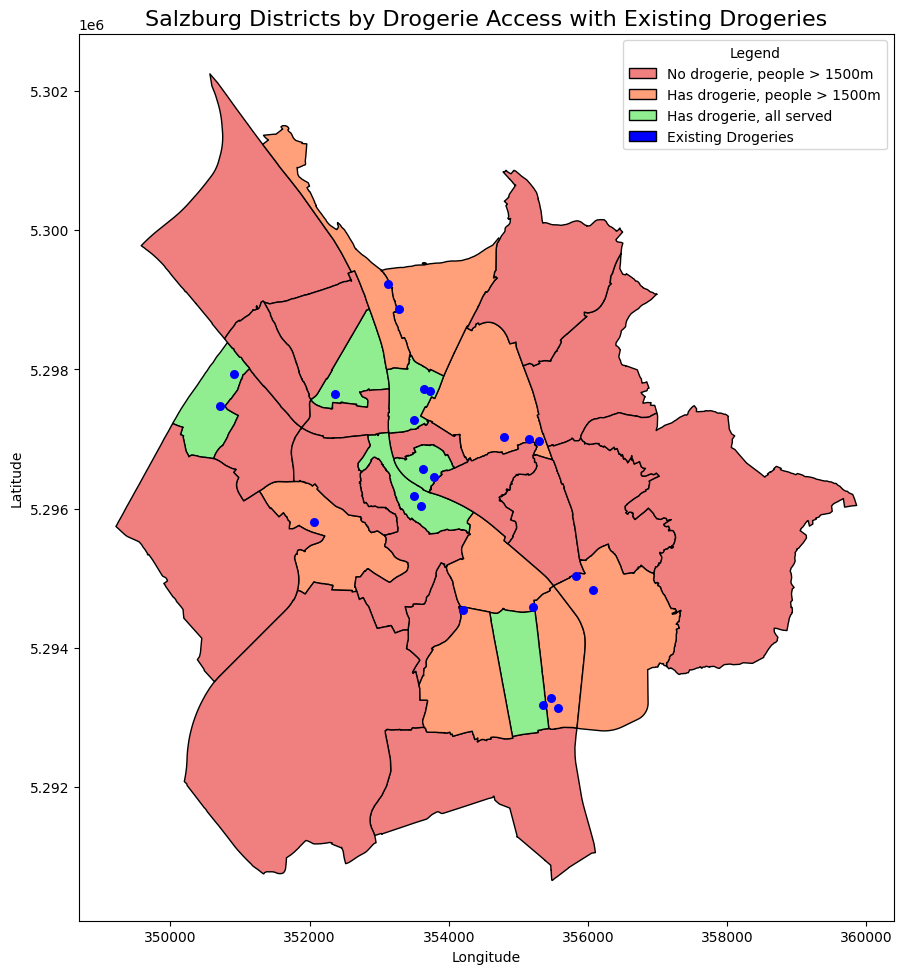

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors for the categories
category_colors = {
    'No drogerie, people > 1500m': 'lightcoral',   # Lighter red
    'Has drogerie, people > 1500m': 'lightsalmon', # Lighter orange
    'All served': 'lightgreen'                      # Lighter green
}

# Create a new column for the colors, fill missing categories with 'white'
districts['color'] = districts['category'].map(category_colors).fillna('lightgreen')

# Load data for the centroids of the drogerie locations
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance12.gpkg"
utm_centroids = gpd.read_file(utm_centroids_path)

# List of 'id' values of the centroids to visualize
target_ids = [
    'way/29280820', 'way/45393138', 'way/48894570', 'way/51070174', 'way/54827797', 
    'way/55227682', 'way/56080144', 'way/56125682', 'way/64132614', 'way/64132870', 
    'way/66058244', 'way/66209398', 'way/96856587', 'way/98347136', 'way/127497381', 
    'way/136339345', 'way/139752447', 'way/171436447', 'way/236372677', 'way/552204886', 
    'way/956550043', 'way/1274259281', 'way/1259480108'
]

# Filter centroids by 'id'
centroids_filtered = utm_centroids[utm_centroids['id'].isin(target_ids)]

# Visualization of the map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot districts colored by category
districts.plot(ax=ax, color=districts['color'], edgecolor='black')

# Add centroids of the old drogeries
centroids_filtered.plot(ax=ax, color='blue', markersize=30, label='Old Drogerie Centroids')

# Manually add a legend
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='black', label='No drogerie, people > 1500m'),
    Patch(facecolor='lightsalmon', edgecolor='black', label='Has drogerie, people > 1500m'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Has drogerie, all served'),
    Patch(facecolor='blue', edgecolor='black', label='Existing Drogeries')  # Bright blue markers for drogeries
]
ax.legend(handles=legend_elements, title="Legend", loc='upper right')

# Title and labels
plt.title("Salzburg Districts by Drogerie Access with Existing Drogeries", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the map
plt.tight_layout()
plt.show()


#### Visualize the number of residents in each district who must walk more than 1500 meters to reach a drugstore: 
Create a horizontal bar chart where each bar represents a district and the number of underserved residents:

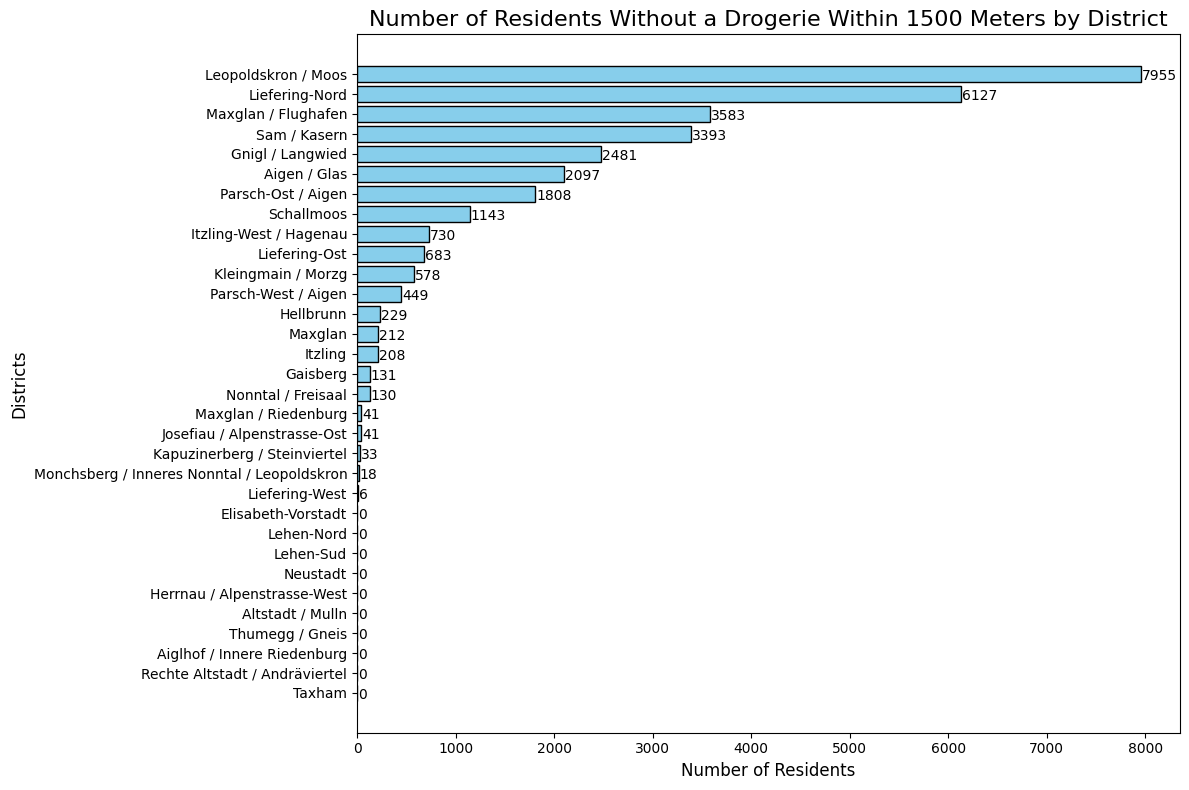

In [8]:
import matplotlib.pyplot as plt

# Prepare the data
districts_sorted = districts.sort_values('distributed_population', ascending=False)  # Sort districts by population
district_names = districts_sorted['NAME']  # District names
population_no_access = districts_sorted['distributed_population']  # Residents without access within 1500m

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(district_names, population_no_access, color='skyblue', edgecolor='black')

# Add title and axis labels
ax.set_title('Number of Residents Without a Drogerie Within 1500 Meters by District', fontsize=16)
ax.set_xlabel('Number of Residents', fontsize=12)
ax.set_ylabel('Districts', fontsize=12)

# Add value labels to each bar
for i in ax.patches:
    ax.text(i.get_width() + 10, i.get_y() + 0.5, f'{int(i.get_width())}', fontsize=10, verticalalignment='center')

# Reverse the Y-axis for better readability (largest bar on top)
plt.gca().invert_yaxis()

# Display the chart
plt.tight_layout()
plt.show()
